# 1.4 - Purging the Series of the Fed Information Effect

This script purges the series created in 1.2 of the Fed Information Effect using the Greenbook forecast data gathered in 1.3. Following Mirranda-Aggripino (2016), taking $s_t$ to be the raw shock for meeting $t$ calculated in 1.2 and $\Gamma_t$ to be a vector of Greenbook forecast data corresponding to meeting $t$, I take $u_t$ to be the *true* shock - that which cannot be explained by the beliefs the Fed currently has about real GDP growth, inflation and unemployment for the current and next 4 quarters, conducting OLS regression as follows...

$$s_t = \alpha + \mathbf{\beta}\cdot\mathbf{\Gamma}_t + u_t$$

Potential specifications for $\Gamma$ are constructed from forecast revisions for...
- all non-empty combinations of real GDP growth, inflation and unemployment.
- Only the current quarter $q_0$, or all data through to $q_1$, $q_2$, $q_3$ or $q_4$, or only data for $q_0$ and $q_4$, or only data for $q_0$,$q_1$ and $q_4$

...providing $7\cdot7=49$ possible specifications.

Specifcations taken forth are...
##### Rewrite

### Preamble

This script makes use of...

- Pandas
- StatsModels

In [133]:
import pandas as pd
import statsmodels.api as sm

### Import the Raw Shock Dataframe

This block imports the raw shock dataframe created in 1.2, and fixes the date indices such that it is commensurable with the Greenbook forecast dataframe.

In [134]:
shock_df = pd.read_csv('shock.csv')

shock_df = shock_df.rename(columns = {'Unnamed: 0':'Date'})

shock_df['Date'] = [pd.Timestamp(date) for date in shock_df['Date']] # .csv format saves dates as strings; this gets them back into Pandas timestamp format
                                                                     
shock_df = shock_df.set_index('Date')

### Add the Nakamura and Steinsson (2018) Series to the Shock Dataframe

In [135]:
ns_df = pd.read_excel('NS_Shocks.xlsx') # Get the Nakamura-Steinsson shock series

ns_df = ns_df.rename(columns = {'date_daily':'Date','policy_news_shocks':'ns_shocks'})

ns_df = ns_df.drop(columns = ['day','month','year','unscheduled_meetings','FFR_shock'])

shock_df = shock_df.merge(ns_df, on = 'Date') # Merge the dataframes - this automatically drops any dates which do not feature in all series

shock_df = shock_df.set_index('Date')

shock_df = shock_df.rename(columns = {'shock':'s_shocks'})

### Import the Greenbook Dataframe

This block imports the greenbook forecast revisions dataframe created in 1.3, fixes the date indices, and corrects for rounding errors from storage in Unix timestamp format.

In [136]:
greenbook_df = pd.read_csv('greenbook.csv')

greenbook_df = greenbook_df.rename(columns = {'Unnamed: 0': ''})

greenbook_df = greenbook_df.set_index('')

greenbook_df = greenbook_df.T

greenbook_df.index = [pd.Timestamp(int(ts) + 21600 - ((int(ts) + 21600) % 86400), unit = 's') for ts in greenbook_df.index]

greenbook_df.index.name = 'Date'

### Get Matching Dataframe Indices

This block drops Greenbook forecast revision data for meeting dates for which I have no shock (currently just 12th November, 1997) 

In [137]:
## Drop dates for which no shocks

greenbook_df = greenbook_df.drop(index = greenbook_df.index[[date not in shock_df.index for date in greenbook_df.index]])

## Check for any dates in the shock index that are not in the Greenbook index (misalignment likely reflects an error in 1.1).

if list(greenbook_df.index) == list(shock_df.index):
    
    print('Indices align.')
    
else:
    
    print('Indices do not align.')

Indices align.


### Initialising the Regressor and Regressand Dataframes

This block gets the raw shock into a single-column regressand dataframe, and adds a constant (i.e. a column of only 1s) to the Greenbook forecast dataframe. The OLS regression method in the StatsModels package is compatible with pandas dataframes, so the data are stored this way as an expedient.

In [138]:
regressand_df = shock_df.drop(columns = shock_df.columns[:-2])

regressor_df = greenbook_df.copy() # For nominal clarity

### Getting String Lists for Each Potential Specification

This block uses some mathematical chicanery to get each of the 49 specifications mentioned above from `spec_list`.

In [139]:
spec_list = [['rgdp_q0','rgdp_q1','rgdp_q2','rgdp_q3','rgdp_q4'],
            ['infl_q0', 'infl_q1', 'infl_q2', 'infl_q3', 'infl_q4'],
            ['unmp_q0', 'unmp_q1', 'unmp_q2', 'unmp_q3', 'unmp_q4']]

def select(List, indices): # This function allows for getting non-consecutive elements from a list.
    return [List[i] for i in indices]

## Get a set of indices for combinations of real GDP growth, inflation and unemployment.

index_list_variables = [select(range(0,15,5),I) for I in [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]]

index_list_full = []

for item in index_list_variables: # This loop gets a set of indices for each of 0, 1, 2, 3 and 4 quarters out.
    
    for i in range(0,5):
        
        periods = []
        
        for j in item:
            
            periods = periods + [j + k for k in range(0,i+1)]
            
        index_list_full.append(periods)
    
for item in index_list_variables:
    
    add04 = []
    
    add014 = []
    
    for x in [[j,j+1,j+4] for j in item]:
        
        add04 = add04 + [x[0]] + [x[2]]
        
        add014 = add014 + x
    
    index_list_full.append(add04)
    
    index_list_full.append(add014)

spec_list_full = [select(list(regressors_df.columns[1:]),subset) for subset in index_list_full] # Gets each specification in terms of strings

### Building Dataframe for Specification Analysis

This block gets the Akaike Information Criterion, Adjusted $R^2$, $R^2$ and number of regressors (`n`) for each specification into a single dataframe, allowing for analysis of each using Pandas' `.sort_values()` method.

In [140]:
## Initialise (rather ugly) dataframe - specifications as index and information for analysis as columns

spec_df = pd.DataFrame(index = [','.join(s) for s in spec_list_full], columns = ['s_aic','s_adj_R^2','s_R^2','n','ns_aic','ns_adj_R^2','ns_R^2'])

for spec in spec_list_full: # Loops through each specification
    
    s_model = sm.OLS(regressand_df['s_shocks'], regressors_df[spec]).fit() # This is the fitting of the model
    
    spec_df.loc[','.join(spec),'s_aic'] = s_model.aic
    
    spec_df.loc[','.join(spec),'s_adj_R^2'] = s_model.rsquared_adj
    
    spec_df.loc[','.join(spec),'s_R^2'] = s_model.rsquared
    
    spec_df.loc[','.join(spec),'n'] = len(spec)
    
    ns_model = sm.OLS(regressand_df['ns_shocks'], regressors_df[spec]).fit()
    
    spec_df.loc[','.join(spec),'ns_aic'] = ns_model.aic
    
    spec_df.loc[','.join(spec),'ns_adj_R^2'] = ns_model.rsquared_adj
    
    spec_df.loc[','.join(spec),'ns_R^2'] = ns_model.rsquared

### (Analysis Conducted to Determine Which Specification to Use)

In [141]:
#spec_df = spec_df.sort_values('s_aic', ascending = True)

#spec_df['s_rank'] = list(range(1,len(spec_df.index)+1))

#spec_df = spec_df.sort_values('ns_aic', ascending = True)

#spec_df['ns_rank'] = list(range(1,len(spec_df.index)+1))

#spec_df['rank_sum'] = spec_df['s_rank'] + spec_df['ns_rank']

#spec_df.sort_values('rank_sum')

### Building the Purged Shock Series Dataframe

This block produces the OLS model for each series carried forth (justifications given above) and gets the residuals into a dataframe.

In [142]:
subset = 'rgdp_q0,rgdp_q1,rgdp_q4,infl_q0,infl_q1,infl_q4'.split(',')

S_model = sm.OLS(regressand_df['s_shocks'], regressors_df[subset]).fit()

NS_model = sm.OLS(regressand_df['ns_shocks'], regressors_df[subset]).fit()

purged_shocks_df = pd.DataFrame(index = greenbook_df.index)

purged_shocks_df['S_shocks'] = S_model.resid # This gets the residuals for each value

purged_shocks_df['NS_shocks'] = NS_model.resid

purged_shocks_df['S_shocks_raw'] = shock_df['s_shocks']

purged_shocks_df['NS_shocks_raw'] = shock_df['ns_shocks']

### Export to *.csv*

In [143]:
purged_shocks_df.to_csv('purged_shocks.csv')

### Data For Table 4

In [144]:
S_model.pvalues

rgdp_q0    0.005396
rgdp_q1    0.450664
rgdp_q4    0.000257
infl_q0    0.025047
infl_q1    0.003487
infl_q4    0.339617
dtype: float64

In [145]:
S_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               s_shocks   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.193
Date:                Thu, 07 Nov 2019   Prob (F-statistic):           7.22e-05
Time:                        04:39:45   Log-Likelihood:                 68.671
No. Observations:                 151   AIC:                            -125.3
Df Residuals:                     145   BIC:                            -107.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rgdp_q0        0.0526      0.019      2.825      0.005       0.016       0.089
rgdp_q1       -0.0175      0.023     -0.756      0.451      -0.063       0.028
rgdp_q4        0.1550      0.041      3.748      0.000       0.073       0.237
infl_q0        0.0554      0.024      2.264      0.025       0.007       0.104
infl_q1        0.1128      0.038      2.970      0.003       0.038       0.188
infl_q4       -0.0926      0.097     -0.958      0.340      -0.284       0.098
==============================================================================
Omnibus:                       34.608   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.733
Skew:                           0.992   Prob(JB):                     9.75e-17
Kurtosis:                       5.789   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
NS_model.pvalues

rgdp_q0    0.079999
rgdp_q1    0.326932
rgdp_q4    0.018898
infl_q0    0.017996
infl_q1    0.245044
infl_q4    0.888809
dtype: float64

In [147]:
NS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ns_shocks   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.489
Date:                Thu, 07 Nov 2019   Prob (F-statistic):            0.00298
Time:                        04:39:45   Log-Likelihood:                 296.04
No. Observations:                 151   AIC:                            -580.1
Df Residuals:                     145   BIC:                            -562.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rgdp_q0        0.0073      0.004      1.763      0.080      -0.001       0.015
rgdp_q1        0.0051      0.005      0.984      0.327      -0.005       0.015
rgdp_q4        0.0218      0.009      2.374      0.019       0.004       0.040
infl_q0        0.0130      0.005      2.393      0.018       0.002       0.024
infl_q1        0.0098      0.008      1.167      0.245      -0.007       0.026
infl_q4        0.0030      0.021      0.140      0.889      -0.039       0.045
==============================================================================
Omnibus:                       41.477   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.907
Skew:                          -1.154   Prob(JB):                     1.49e-21
Kurtosis:                       6.149   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Producing Figure 2

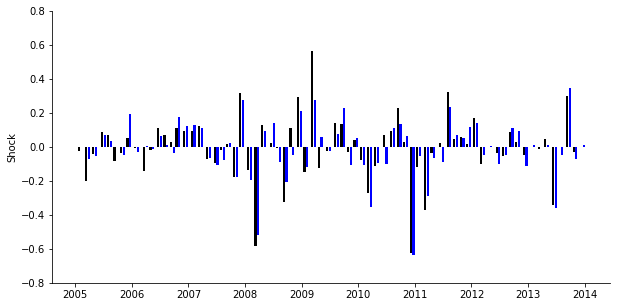

In [148]:
both_df = pd.DataFrame(index = shock_df.index)

both_df['Raw'] = -1*shock_df['s_shocks']

both_df['Purged'] = -1*purged_shocks_df['S_shocks']

from matplotlib import pyplot as plt

y1 = both_df.Raw.values[79:]

x1 = both_df.index[79:] + pd.DateOffset(days = -9)

y2 = both_df.Purged.values[79:]

x2 = both_df.index[79:] + pd.DateOffset(days = 9)

fig = plt.figure(figsize = (10,5))

plt.bar(x1,y1, width = 14, color = 'k')

plt.bar(x2,y2, width = 14, color = 'b')

plt.ylabel('Shock')

plt.ylim([-0.8,0.8])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

### Determining Number of Sign Changes

In [149]:
print(sum(shock_df['s_shocks']*purged_shocks_df['S_shocks'] < 0),sum(shock_df['ns_shocks']*purged_shocks_df['NS_shocks'] < 0))

21 22


### Determining Mean Absolute Values of Series Undergoing Sign Changes

In [156]:
print(abs(shock_df.loc[(shock_df['s_shocks']*purged_shocks_df['S_shocks'] < 0)].s_shocks).mean())

print(abs(shock_df.s_shocks).mean())

print(abs(shock_df.loc[(shock_df['ns_shocks']*purged_shocks_df['NS_shocks'] < 0)].ns_shocks).mean())

print(abs(shock_df.ns_shocks).mean())

0.057465421779913775
0.11791674677415513
0.010000854545454546
0.02528477682119206


### Getting pre-Purge Correlations

In [161]:
shock_df.corr()

,ED6,ED12,ED24,FFR_t0t1,FFR_t1t2,s_shocks,ns_shocks
ED6,1.000000,0.851280,0.649012,0.285034,0.364461,0.938774,0.388054
ED12,0.851280,1.000000,0.900475,0.235647,0.316436,0.971814,0.369848
ED24,0.649012,0.900475,1.000000,0.170915,0.232061,0.855950,0.316537
FFR_t0t1,0.285034,0.235647,0.170915,1.000000,0.787057,0.317810,0.609664
FFR_t1t2,0.364461,0.316436,0.232061,0.787057,1.000000,0.405891,0.769512
s_shocks,0.938774,0.971814,0.855950,0.317810,0.405891,1.000000,0.437455
ns_shocks,0.388054,0.369848,0.316537,0.609664,0.769512,0.437455,1.000000


In [162]:
shock_df[shock_df.index < pd.Timestamp('2008-12-01')].corr()

,ED6,ED12,ED24,FFR_t0t1,FFR_t1t2,s_shocks,ns_shocks
ED6,1.000000,0.904312,0.716194,0.315709,0.408392,0.963729,0.422103
ED12,0.904312,1.000000,0.909652,0.275930,0.400897,0.978410,0.413924
ED24,0.716194,0.909652,1.000000,0.179658,0.289374,0.859183,0.344547
FFR_t0t1,0.315709,0.275930,0.179658,1.000000,0.778091,0.358134,0.593129
FFR_t1t2,0.408392,0.400897,0.289374,0.778091,1.000000,0.476305,0.775207
s_shocks,0.963729,0.978410,0.859183,0.358134,0.476305,1.000000,0.477287
ns_shocks,0.422103,0.413924,0.344547,0.593129,0.775207,0.477287,1.000000


In [163]:
shock_df[shock_df.index >= pd.Timestamp('2008-12-01')].corr()

,ED6,ED12,ED24,FFR_t0t1,FFR_t1t2,s_shocks,ns_shocks
ED6,1.000000,0.838338,0.641419,0.171332,0.185451,0.907546,0.260041
ED12,0.838338,1.000000,0.897685,0.270796,0.251160,0.982106,0.353997
ED24,0.641419,0.897685,1.000000,0.306996,0.271771,0.891001,0.358628
FFR_t0t1,0.171332,0.270796,0.306996,1.000000,0.963495,0.285590,0.869288
FFR_t1t2,0.185451,0.251160,0.271771,0.963495,1.000000,0.274085,0.894324
s_shocks,0.907546,0.982106,0.891001,0.285590,0.274085,1.000000,0.365714
ns_shocks,0.260041,0.353997,0.358628,0.869288,0.894324,0.365714,1.000000
